v.d.10: Classificação se é fato gerador ou não e da categoria (SE, CI, CA) de uma só fez (4 categorias: NÃO, SE, CI, CA) e em 2 etapas, utilizando TF-IDF sem e com limpeza de dados, balanceamento, otimização de hiperparâmetros e cross validation, feature importance do algoritimo de SGDClassifier. Além disso, será utilizado o dataset ampliado e uma amostra na otimização de hiperparâmetros.

# Classificação de lançamentos contábeis

1) Descrição do problema: classificar a despesa pública natureza 339036 (outros serviços - pessoa física) com base no histórico da nota de empenho como fato gerador, ou não, das contribuições previdenciárias.

2) Descrição da solução: Construção de features com base no texto do histórico das notas de empenho, treinamento e teste para seleção do modelo de classificação com melhor métrica de desempenho.

3) Fonte de dados: Os dados das notas de empenho estão disponíveis em portais da transparência de diversos órgãos públicos, por exemplo,
https://www.governotransparente.com.br/acessoinfo/44529487/empenhoportipo. No caso, será utilizada uma base de dados rotulados a partir desses dados públicos.

4) Variáveis independentes: texto com o histórico da nota de empenho.

5) Variável dependente. Primeiramente, será classificado apenas como 0 (não é fato gerador) e 1 (é fato gerador). Posteriormente, a classificação incluirá a categoria do segurado: segurado empregado, contribuinte individual, contribuinte individual – condutor autônomo.

## 1. Carregamento dos dados e importação das bibliotecas

In [15]:
# Monta google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Carrega os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Importa bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Configurações
pd.set_option('display.max_colwidth', None)

In [17]:
# Importa os dados
df_completo = pd.read_json('/content/drive/My Drive/projeto classificacao de lancamento/dados/despesa liquidada - base completa - texto processado.json')
df_completo.head()

,descricao,fato_gerador,categoria,descricao_limpa,descricao_lematizada
0,"Locacao de imovel para funcionamento da casa de apoio da Equipe Tatico metropolitana de Concordia do Para, no periodo de 01 de Janeiro a 31 de Dezembro de 2019.",Não,Não,locacao imovel funcionamento casa apoio equipe tatico metropolitana,locacao imovel funcionamento casa apoio equipe tatico metropolitana
1,"Locacao de imovel para funcionamento do arquivo de documentos inativos e deposito de materiais inserviveis do Municipio de Concordia do Para, no periodo de 01 de janeiro a 31 de dezembro de 2019.",Não,Não,locacao imovel funcionamento arquivo documentos inativos deposito materiais inserviveis municipio,locacao imovel funcionamento arquivo documento inativo deposito material inservivei municipio
2,"servicos eventuais prestados para atender a Secretaria Municipal de Obras e Transportes, como Mecanico de veiculos da secretaria durante o mes de Janeiro de 2019.",Sim,CI,eventuais obras transportes mecanico veiculos,eventual obra transporte mecanico veiculo
3,"servicos eventuais prestados como Auxiliar de Servicos Gerais para atender a Secretaria Municipal de Administracao, durante 12 dias do mes de Janeiro de 2019.",Sim,CI,eventuais auxiliar gerais administracao dias,eventual auxiliar geral administracao dia
4,"servicos eventuais prestados como Vigia para atender a Secretaria Municipal de Administracao, durante 10 dias do mes de Janeiro de 2019.",Sim,CI,eventuais vigia administracao dias,eventual vigia administracao dia


In [18]:
# Construção de dataframe com as colunas de interesse
df = df_completo[['descricao_lematizada', 'fato_gerador', 'categoria']]
df.head()

,descricao_lematizada,fato_gerador,categoria
0,locacao imovel funcionamento casa apoio equipe tatico metropolitana,Não,Não
1,locacao imovel funcionamento arquivo documento inativo deposito material inservivei municipio,Não,Não
2,eventual obra transporte mecanico veiculo,Sim,CI
3,eventual auxiliar geral administracao dia,Sim,CI
4,eventual vigia administracao dia,Sim,CI


In [19]:
df['categoria'].value_counts()

,count
categoria,
CI,28259
Não,7873
CA,1100
SE,335


## 2. Balanceamento de classes

A melhor prática é utilizar os dados de teste sem balanceamento de classes.

Motivo:
- O objetivo da avaliação do modelo é medir o desempenho do modelo em um conjunto de dados que ele não viu durante o treinamento.
- O balanceamento de classes é uma técnica utilizada para melhorar o desempenho do modelo durante o treinamento, mas não deve ser utilizado para avaliar o desempenho final do modelo.
- Se utilizarmos dados balanceados para avaliação, o resultado pode ser otimista, pois o modelo pode estar aprendendo a classificar melhor as classes minoritárias apenas porque elas foram superamostradas durante o treinamento.
- Em um cenário real, as classes minoritárias podem estar subrepresentadas, e o modelo pode ter dificuldades para classificá-las corretamente.
Portanto, para uma avaliação mais realista do desempenho do modelo, é importante utilizar os dados de teste sem balanceamento de classes.
- Desta forma, é possível medir o desempenho do modelo em um cenário mais próximo da realidade.

### 2.1. Avaliação do modelo sem balanceamento de classes

Classification Report
              precision    recall  f1-score   support

          CA       0.97      0.93      0.95       330
          CI       0.99      1.00      0.99      8478
         Não       1.00      0.98      0.99      2362
          SE       1.00      0.90      0.95       101

    accuracy                           0.99     11271
   macro avg       0.99      0.95      0.97     11271
weighted avg       0.99      0.99      0.99     11271

F1 Score: 0.992052484291043

Confusion Matrix


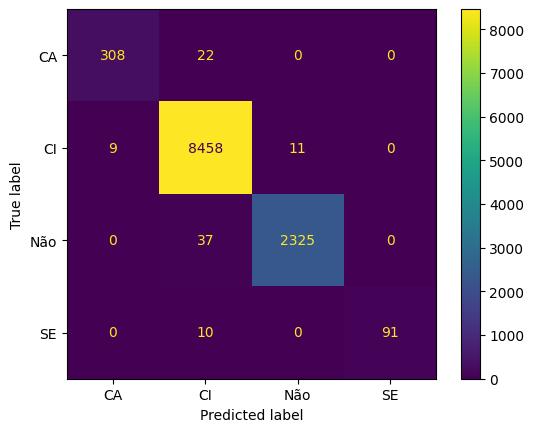

In [20]:
# Definição do pipeline com extrator de features do texto e classificador
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', SGDClassifier(random_state=42))
])

# Separação entre variáveis preditoras e alvo e divisão em treino e teste
X = df['descricao_lematizada']
y = df['categoria']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Ajuste do modelo
pipeline.fit(X_train, y_train)

# Avaliação do modelo classification report e confusion matrix
y_pred = pipeline.predict(X_test)
print('Classification Report')
print(classification_report(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))
print('\nConfusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

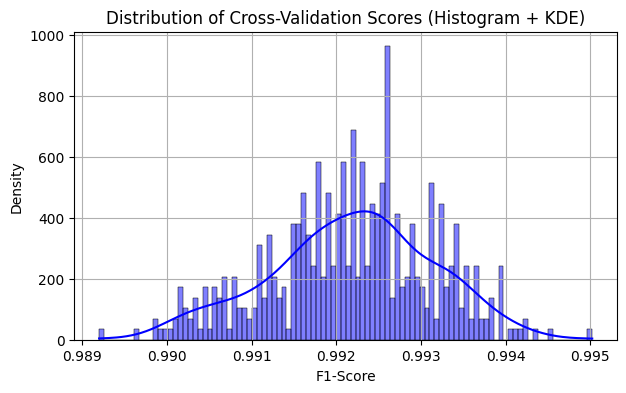

F1-Score médio: 0.992177
Desvio padrão: 0.000963


In [7]:
# Definição da estratégia de validação cruzada com 5 folds e 20 repetições e avaliação do modelo
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_weighted')

# Plotando o histograma dos scores com curva de densidade (KDE)
plt.figure(figsize=(7, 4))
sns.histplot(scores, kde=True, bins=100, color='blue', stat='density')
plt.title('Distribution of Cross-Validation Scores (Histogram + KDE)')
plt.xlabel('F1-Score')
plt.ylabel('Density')
plt.grid(True)
plt.show()
print(f"F1-Score médio: {np.mean(scores):.6f}")
print(f"Desvio padrão: {np.std(scores):.6f}")

### 2.2 Avaliação do modelo com balanceamento de classes

In [21]:
# Definição da função para calcular a quantidade a partir da razão
def ratio_multiplier(y, multiplier):
    target_stats = Counter(y)
    for key, value in target_stats.items():
        if key in multiplier:
            target_stats[key] = int(value * multiplier[key])
    return target_stats

# Definição da função para realizar o balancemento
def class_balancing(df, over_sampler, under_sampler, over_multiplier, under_multiplier):

    # Definição do pipeline com extrator de features do texto, balanceamento e classificador
    imb_pipeline = ImbPipeline([
        ('tfidf', TfidfVectorizer()),
        ('over', over_sampler(sampling_strategy=lambda x: ratio_multiplier(x, over_multiplier), random_state=42)),
        ('under', under_sampler(sampling_strategy=lambda x: ratio_multiplier(x, under_multiplier), random_state=42)),
        ('classifier', SGDClassifier(random_state=42))
    ])

    # Separação entre variáveis preditoras e alvo e divisão em treino e teste
    X = df['descricao_lematizada']
    y = df['categoria']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    # Balanceamento de classes
    imb_pipeline.fit(X_train, y_train)

    # Avaliação do modelo classification
    y_pred = imb_pipeline.predict(X_test)
    print('\nClassification Report')
    print(classification_report(y_test, y_pred))
    print('F1 Score:', f1_score(y_test, y_pred, average='weighted'))
    print('\nConfusion Matrix')
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

    return imb_pipeline

#### 2.2.1. Balanceamento com RandomOverSampler e RandomUnderSampler


Classification Report
              precision    recall  f1-score   support

          CA       0.96      0.97      0.97       330
          CI       0.99      0.99      0.99      8478
         Não       1.00      0.98      0.99      2362
          SE       0.81      1.00      0.89       101

    accuracy                           0.99     11271
   macro avg       0.94      0.99      0.96     11271
weighted avg       0.99      0.99      0.99     11271

F1 Score: 0.9916765214421304

Confusion Matrix


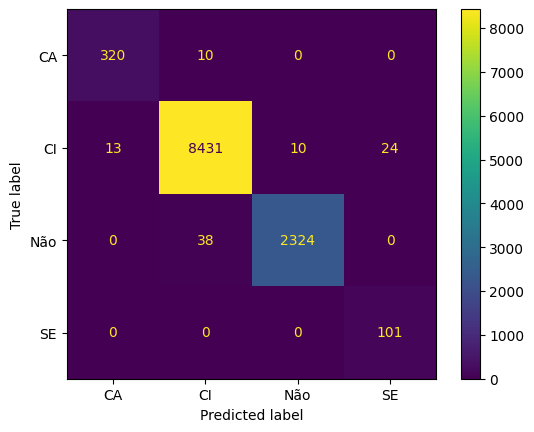

In [22]:
# Definição dos métodos de oversampling e undersampling
over_sampler = RandomOverSampler
under_sampler = RandomUnderSampler

# Estratégia: dobrar o tamanho das classes minoritárias e reduzir à metade o das majoritárias.
over_multiplier = {'CI': 1, 'Não': 1, 'CA': 2, 'SE': 2}
under_multiplier = {'CI': 1, 'Não': 1, 'CA': 1, 'SE': 1}

# Aplicação das estratégias
imb_model = class_balancing(df, over_sampler, under_sampler, over_multiplier, under_multiplier)

**Análise:** a estratégia de balanceamento, apesar de diminuir os falsos negativos das classes minoritárias (aumentou recall), aumentou seus falsos positivos (diminuiu precision), comportamento indesejável para a área de negócio.

**Nova estratégia:** aumentar gradativamente as classes minoritárias sem que o efeito acima descrito ocorra.


Classification Report
              precision    recall  f1-score   support

          CA       0.97      0.97      0.97       330
          CI       0.99      1.00      1.00      8478
         Não       0.99      0.98      0.99      2362
          SE       1.00      0.93      0.96       101

    accuracy                           0.99     11271
   macro avg       0.99      0.97      0.98     11271
weighted avg       0.99      0.99      0.99     11271

F1 Score: 0.9930633906231412

Confusion Matrix


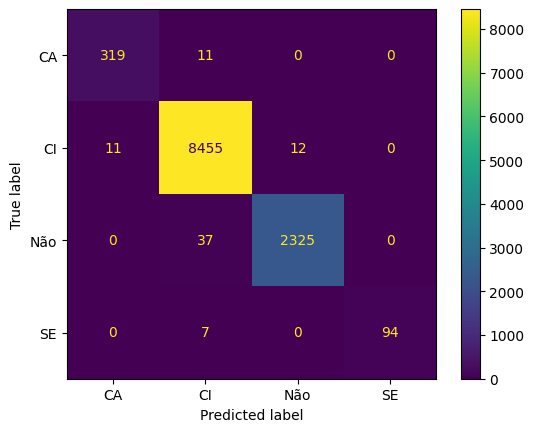

In [23]:
# Definição dos métodos de oversampling e undersampling
over_sampler = RandomOverSampler
under_sampler = RandomUnderSampler

# Estratégia: dobrar o tamanho das classes minoritárias e reduzir à metade o das majoritárias.
over_multiplier = {'CI': 1, 'Não': 1, 'CA': 1.9, 'SE': 1.45}
under_multiplier = {'CI': 1, 'Não': 1, 'CA': 1, 'SE': 1}

# Aplicação das estratégias
imb_model = class_balancing(df, over_sampler, under_sampler, over_multiplier, under_multiplier)

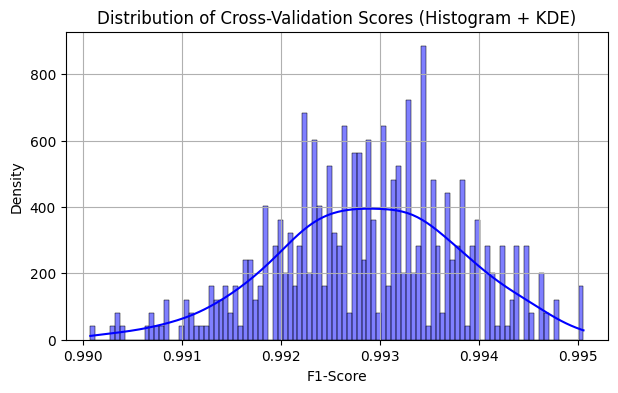

F1-Score médio: 0.992877
Desvio padrão: 0.000932


In [11]:
# Definição da estratégia de validação cruzada com 5 folds e 100 repetições e avaliação do modelo treinado com o melhor balanceamento.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100, random_state=42)
scores = cross_val_score(imb_model, X, y, cv=cv, scoring='f1_weighted')

# Plotando o histograma dos scores com curva de densidade (KDE)
plt.figure(figsize=(7, 4))
sns.histplot(scores, kde=True, bins=100, color='blue', stat='density')
plt.title('Distribution of Cross-Validation Scores (Histogram + KDE)')
plt.xlabel('F1-Score')
plt.ylabel('Density')
plt.grid(True)
plt.show()
print(f"F1-Score médio: {np.mean(scores):.6f}")
print(f"Desvio padrão: {np.std(scores):.6f}")

#### 2.2.2. Balanceamento de classes com SMOTE e RandomUnderSampler


Classification Report
              precision    recall  f1-score   support

          CA       0.96      0.97      0.96       330
          CI       0.99      1.00      1.00      8478
         Não       1.00      0.98      0.99      2362
          SE       1.00      0.93      0.96       101

    accuracy                           0.99     11271
   macro avg       0.99      0.97      0.98     11271
weighted avg       0.99      0.99      0.99     11271

F1 Score: 0.9931553175541955

Confusion Matrix


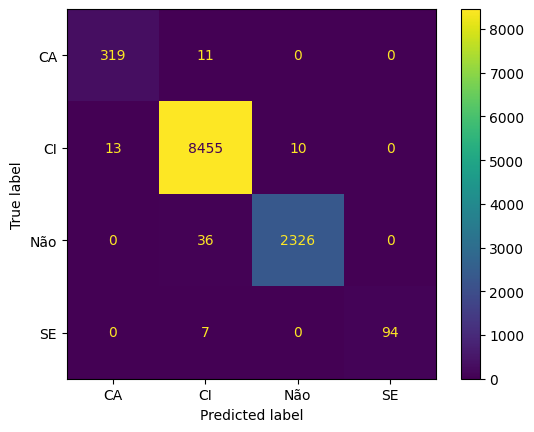

In [12]:
# Definição dos métodos de oversampling e undersampling
over_sampler = SMOTE
under_sampler = RandomUnderSampler

# Estratégia: dobrar o tamanho das classes minoritárias e reduzir à metade o das majoritárias.
over_multiplier = {'CI': 1, 'Não': 1, 'CA': 1.9, 'SE': 1.45}
under_multiplier = {'CI': 1, 'Não': 1, 'CA': 1, 'SE': 1}

# Aplicação das estratégias
smote_model = class_balancing(df, over_sampler, under_sampler, over_multiplier, under_multiplier)

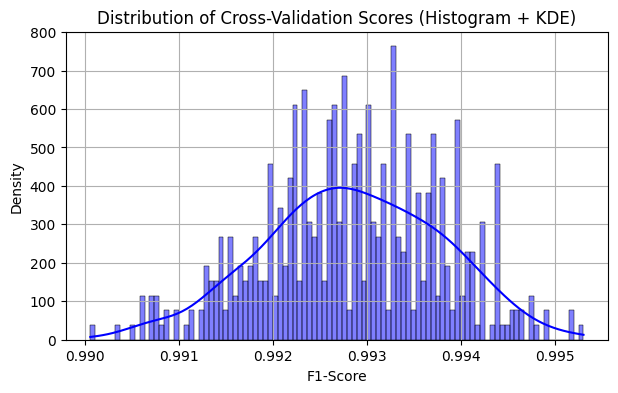

F1-Score médio: 0.992840
Desvio padrão: 0.000943


In [13]:
# Definição da estratégia de validação cruzada com 5 folds e 100 repetições e avaliação do modelo treinado com o melhor balanceamento.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=100, random_state=42)
scores = cross_val_score(smote_model, X, y, cv=cv, scoring='f1_weighted')

# Plotando o histograma dos scores com curva de densidade (KDE)
plt.figure(figsize=(7, 4))
sns.histplot(scores, kde=True, bins=100, color='blue', stat='density')
plt.title('Distribution of Cross-Validation Scores (Histogram + KDE)')
plt.xlabel('F1-Score')
plt.ylabel('Density')
plt.grid(True)
plt.show()
print(f"F1-Score médio: {np.mean(scores):.6f}")
print(f"Desvio padrão: {np.std(scores):.6f}")

## 3. Conclusão
O aumento excessivo da quantidade de observações nas classes minoritárias  fez com que o modelo acertasse mais vezes a classificação nas classes minoritárias, mas também classificasse erroneamente outras observações nas classes minoritárias.

O melhor equilíbrio entre precision e recall foi alcançado aumentando a menor classe (SE) em 45% e a segunda menor classe (CA) em 90%.

- over_multiplier = {'CI': 1, 'Não': 1, 'CA': 1.9, 'SE': 1.45}
- under_multiplier = {'CI': 1, 'Não': 1, 'CA': 1, 'SE': 1}

O resultado foi muito próximo utilizando RandomOverSampler e SMOTE.

## 4. Exportação do dataset balanceado

In [24]:
# Aplicação da melhor estratégia de balanceamento e exportação do dataset balanceado para próxima fase do projeto
# Definição dos métodos de oversampling e undersampling e multiplicadores
over_sampler = RandomOverSampler
under_sampler = RandomUnderSampler
over_multiplier = {'CI': 1, 'Não': 1, 'CA': 1.9, 'SE': 1.45}
under_multiplier = {'CI': 1, 'Não': 1, 'CA': 1, 'SE': 1}

# Definição do pipeline de balanceamento
imb_pipeline = ImbPipeline([
    ('over', over_sampler(sampling_strategy=lambda x: ratio_multiplier(x, over_multiplier), random_state=42)),
    ('under', under_sampler(sampling_strategy=lambda x: ratio_multiplier(x, under_multiplier), random_state=42)),
])

# Ajuste e transformação do df_completo e reindexação do df_balanceado
df_balanceado, y_balanceado = imb_pipeline.fit_resample(df_completo, df_completo['categoria'])
df_balanceado.reset_index(drop=True, inplace=True)

# Exportação do dataset balanceado para arquivo formato json
df_balanceado.to_json('/content/drive/My Drive/projeto classificacao de lancamento/dados/despesa liquidada - base completa - texto processado - balanceado.json')